In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras


Les données contiennent des images de visage recadrées de 16 personnes réparties en formation et en test. Nous allons entraîner le modèle CNN en utilisant les images du dossier Training, puis tester le modèle en utilisant les images invisibles du dossier de test, pour vérifier si le modèle est capable de reconnaître le numéro de visage des images invisibles ou non.



In [2]:
# Modèle CNN d'apprentissage profond pour reconnaître le visage
'''Ce script utilise une base de données d'images et crée un modèle CNN dessus pour tester
   si l'image donnée est reconnue correctement ou non'''
 
'''########PRÉTRAITEMENT D'IMAGES pour les données de FORMATION et de TEST#######'''
 
# Spécifier le dossier où les images sont présentes
TrainingImagePath='./Face_Images/Face Images/Final Training Images'
TestImagePath='Face_Images/Face Images/Final Testing Images/face13/2face13.jpg'
from keras.preprocessing.image import ImageDataGenerator
# En savoir plus sur ImageDataGenerator au lien ci-dessous
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
 
# Définition des transformations de prétraitement sur les images raw des données d'entraînement
# Ces hyperparamètres permettent de générer des versions légèrement tordues
# de l'image originale, ce qui conduit à un meilleur modèle, car il apprend
# sur le bon et le mauvais mélange d'images
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
 
# Définition des transformations de prétraitement sur les images raw des données de test
# Aucune transformation n'est effectuée sur les images de test
test_datagen = ImageDataGenerator()
 
# Générer les données d'entraînement
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')
 
 
# Générer les données de test
test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')
 
# Affichage d'étiquettes de classe pour chaque face
test_set.class_indices

Found 244 images belonging to 16 classes.
Found 244 images belonging to 16 classes.


{'face1': 0,
 'face10': 1,
 'face11': 2,
 'face12': 3,
 'face13': 4,
 'face14': 5,
 'face15': 6,
 'face16': 7,
 'face2': 8,
 'face3': 9,
 'face4': 10,
 'face5': 11,
 'face6': 12,
 'face7': 13,
 'face8': 14,
 'face9': 15}

# Création d'un mappage pour les noms d'index et de visage

Le dictionnaire class_index ci-dessus a des noms de visage comme clés et le mappage numérique comme valeurs. Nous devons l'échanger, car le modèle de classificateur renverra la réponse sous forme de mappage numérique et nous devons en extraire le nom de visage.

De plus, puisqu'il s'agit d'un problème de classification multi-classes, nous comptons le nombre de faces uniques, car cela sera utilisé comme le nombre de neurones de sortie dans la couche de sortie du classificateur ANN entièrement connecté.

In [3]:
'''############ Creating lookup table for all faces ############'''
# class_indices have the numeric tag for each face
TrainClasses=training_set.class_indices
 
# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName
 
# Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)
 
# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)
 
# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'face1', 1: 'face10', 2: 'face11', 3: 'face12', 4: 'face13', 5: 'face14', 6: 'face15', 7: 'face16', 8: 'face2', 9: 'face3', 10: 'face4', 11: 'face5', 12: 'face6', 13: 'face7', 14: 'face8', 15: 'face9'}

 The Number of output neurons:  16


# Création du modèle de reconnaissance faciale CNN

Dans l'extrait de code ci-dessous, j'ai créé un modèle CNN avec

2 couches cachées de convolution

2 couches cachées de pooling maximum

1 couche d'aplatissement

1 couche ANN cachée

1 couche de sortie avec 16 neurones (un pour chaque face)

Vous pouvez augmenter ou diminuer la convolution, la mise en commun maximale, les couches ANN cachées et le nombre de neurones qu'elles contiennent.


Gardez simplement à l'esprit que plus vous ajoutez de couches / neurones, plus le modèle est lent.


De plus, lorsque vous avez une grande quantité d'images, de l'ordre de 50K et plus, le processeur de votre ordinateur portable peut ne pas être efficace pour apprendre ces nombreuses images. Vous devrez vous procurer un ordinateur portable compatible GPU ou utiliser des services cloud comme AWS ou Google Cloud.


Étant donné que les données que nous avons utilisées pour la démonstration sont petites et ne contiennent que 244 images pour la formation, vous pouvez l'exécuter facilement sur votre ordinateur portable 


Outre la sélection du meilleur nombre de couches et du nombre de neurones qu'il contient, pour chaque couche, certains hyper paramètres doivent également être réglés.


Jetez un coup d'œil à certains des hyperparamètres importants


Filtres = 32: ce nombre indique le nombre de filtres que nous utilisons pour regarder les pixels de l'image pendant l'étape de convolution. Certains filtres peuvent capturer des bords nets, certains filtres peuvent capturer des variations de couleur, certains filtres peuvent capturer des contours, etc. En fin de compte, nous obtenons des informations importantes à partir des images. Dans la première couche, le nombre de filtres = 32 est couramment utilisé, puis augmentant la puissance de 2. Comme dans la couche suivante, il est de 64, dans la couche suivante, il est de 128 et ainsi de suite.

kernel_size = (5,5) : Ceci indique la taille de la fenêtre glissante pendant la convolution, dans cette étude de cas, nous utilisons une fenêtre glissante de 5X5 pixels.

strides = (1, 1): À quelle vitesse ou lentement la fenêtre coulissante doit-elle se déplacer pendant la convolution. Nous utilisons le réglage le plus bas de 1X1 pixels. Cela signifie faire glisser la fenêtre de convolution de 5X5 (kernal_size) de 1 pixel sur l'axe x et de 1 pixel sur l'axe y jusqu'à ce que l'image entière soit balayée.

input_shape = (64,64,3): Les images ne sont rien d'autre qu'une matrice de codes de couleur RVB. lors de notre prétraitement des données, nous avons compressé les images en 64X64, donc la forme attendue est 64X64X3. Signifie 3 tableaux de 64X64, un pour les couleurs RVB chacun.

kernel_initializer = 'uniform' : Lorsque les neurones commencent leur calcul, un algorithme doit décider de la valeur de chaque poids. Ce paramètre spécifie cela. Vous pouvez choisir différentes valeurs comme «normal» ou «glorot_uniform».

activation = 'relu' : Ceci spécifie la fonction d'activation pour les calculs à l'intérieur de chaque neurone. Vous pouvez choisir des valeurs telles que «relu», «tanh», «sigmoid», etc.

optimizer = 'adam':  Ce paramètre permet de trouver les valeurs optimales de chaque poids dans le réseau neuronal. 'adam' est l'un des optimiseurs les plus utiles, un autre est 'rmsprop'

batch_size = 10 : Ceci spécifie combien de lignes seront transmises au réseau en une fois, après quoi le calcul SSE commencera et le réseau neuronal commencera à ajuster ses poids en fonction des erreurs.

Lorsque toutes les lignes sont passées dans les lots de 10 lignes chacun comme spécifié dans ce paramètre, nous appelons cette 1-epoch. Ou un cycle de données complet. Ceci est également connu sous le nom de descente de gradient mini-batch. Une petite valeur de batch_size obligera le LSTM à regarder les données lentement, comme 2 lignes à la fois ou 4 lignes à la fois, ce qui pourrait entraîner un surajustement, par rapport à une valeur élevée comme 20 ou 50 lignes à la fois, ce qui faire en sorte que le LSTM examine rapidement les données, ce qui pourrait entraîner un sous-ajustement. Par conséquent, une valeur appropriée doit être choisie en utilisant le réglage des hyperparamètres.
Epoques = 10 : La même activité d'ajustement des poids se poursuit 10 fois, comme spécifié par ce paramètre. En termes simples, le LSTM examine les données d'entraînement complètes 10 fois et ajuste ses poids.


In [24]:
'''######################## Creation du model CNN deep learning  ########################'''
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
 
'''Initialisation du reseau de neurone convolutif'''
classifier= Sequential()
 
''' Etape--1 Convolution
# Ajout de la première couche de CNN
# nous utilisons le format (64,64,3) car nous utilisons le backend TensorFlow
# Cela signifie 3 matrice de taille (64X64) pixels représentant les composants Rouges, Verts et Bleus des pixels
'''
classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu'))
 
'''# SEtape--2 MAX Pooling'''
classifier.add(MaxPool2D(pool_size=(2,2)))
 
'''# COUCHE SUPPLÉMENTAIRE de CONVOLUTION pour une meilleure précision '''
classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
 
classifier.add(MaxPool2D(pool_size=(2,2)))

'''# Etape--3 FLattening'''
classifier.add(Flatten())
 
'''# Etape--4 Fully Connected Neural Network'''
classifier.add(Dense(64, activation='relu'))
 
classifier.add(Dense(OutputNeurons, activation='softmax'))
 
'''# Compiling the CNN'''
#classificateur.compiler(perte='binary_crossentropy', optimiseur='adam', métriques=['précision'])
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
 
###########################################################
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Starting the model training
history = classifier.fit_generator(
                    training_set,                    
                    epochs=10,
                    validation_data=test_set,
                    validation_steps=10)

# classifier.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# history = classifier.fit(TrainingImagePath, training_set, epochs=10, 
#                     validation_data=(test_image, test_set))

EndTime=time.time()
print("Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/10
8/8 [==============================] - 15s 2s/step - loss: 145.5473 - accuracy: 0.0730 - val_loss: 3.2061 - val_accuracy: 0.0820
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 2.9366 - accuracy: 0.0692
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 2.5147 - accuracy: 0.2301
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 2.0280 - accuracy: 0.3836
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.2899 - accuracy: 0.5926
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.9493 - accuracy: 0.6811
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.5733 - accuracy: 0.8551
Epoch 8/10
8/8 [==============================] - 9s 1s/step - loss: 0.3959 - accuracy: 0.8920
Epoch 9/10
8/8 [==============================] - 9s 1s/step - loss: 0.3214 - accuracy: 0.9140
Epoch 10/10
8/8 [==============================] - 9s 1s/step - loss: 0.1700 - accuracy: 0.9480
T

# Test du classificateur CNN sur des images invisibles
En utilisant l'une des images du dossier de données de test, nous pouvons vérifier si le modèle est capable de reconnaître le visage.

In [28]:

''' Making single predictions '''
import numpy as np
from keras.preprocessing import image
 
TestImagePath='Face_Images/Face Images/Final Testing Images/face2/1face2.jpg'
test_image=image.load_img(TestImagePath,target_size=(64, 64))
test_image=image.img_to_array(test_image)
 
test_image=np.expand_dims(test_image,axis=0)
 
result=classifier.predict(test_image,verbose=0)
#print(training_set.class_indices)
 
print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

########################################
Prediction is:  face2


IsADirectoryError: [Errno 21] Is a directory: 'Face_Images/Face Images/Final Testing Images'

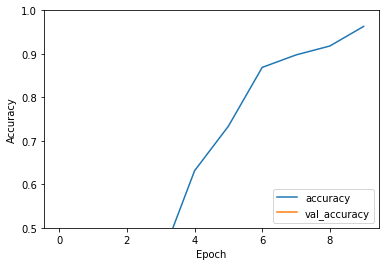

In [35]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test=image.load_img("Face_Images/Face Images/Final Testing Images",target_size=(64, 64))
test_loss, test_acc = classifier.evaluate(test, test_set, verbose=2)

# Conclusion
Vous pouvez modifier ce modèle pour créer un modèle de classification pour n'importe quel groupe d'images. Mettez simplement les images de chaque catégorie dans son dossier respectif et entraînez le modèle.

L'algorithme CNN nous a aidés à créer de nombreuses applications géniales autour de nous! Facebook est l'exemple parfait! Il a formé son modèle DeepFace CNN sur des millions d'images et a une précision de 97% pour reconnaître n'importe qui sur Facebook. Cela peut même surpasser les humains! comme vous vous en souvenez seulement quelques visages 

CNN est également utilisé dans l'industrie médicale pour aider les médecins à obtenir une prédiction précoce du cancer bénin ou malin en utilisant les images de la tumeur. De même, faites-vous une idée de la typhoïde en regardant les images radiographiques, etc.

Les usages de CNN sont nombreux et se développent rapidement autour de nous!